In [2]:
# import modules
import joblib
import pandas as pd
import numpy as np
import pytz
from  datetime import datetime, timedelta
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.models import load_model

from utils import load_file, localize_tz, additive_decom, calculate_technical_indicators,split_data, fit_scaler

from scikeras.wrappers import KerasRegressor

Epoch 1/13
212/212 [==============================] - 8s 20ms/step - loss: 0.0105
Epoch 2/13
212/212 [==============================] - 5s 22ms/step - loss: 9.3662e-04
Epoch 3/13
212/212 [==============================] - 5s 25ms/step - loss: 8.4825e-04
Epoch 4/13
212/212 [==============================] - 5s 23ms/step - loss: 7.6271e-04
Epoch 5/13
212/212 [==============================] - 5s 23ms/step - loss: 6.7539e-04
Epoch 6/13
212/212 [==============================] - 4s 18ms/step - loss: 6.9151e-04
Epoch 7/13
212/212 [==============================] - 5s 23ms/step - loss: 6.0092e-04
Epoch 8/13
212/212 [==============================] - 4s 20ms/step - loss: 6.2493e-04
Epoch 9/13
212/212 [==============================] - 5s 23ms/step - loss: 5.4853e-04
Epoch 10/13
212/212 [==============================] - 5s 22ms/step - loss: 5.6394e-04
Epoch 11/13
212/212 [==============================] - 4s 20ms/step - loss: 6.1459e-04
Epoch 12/13
212/212 [==============================] - 4

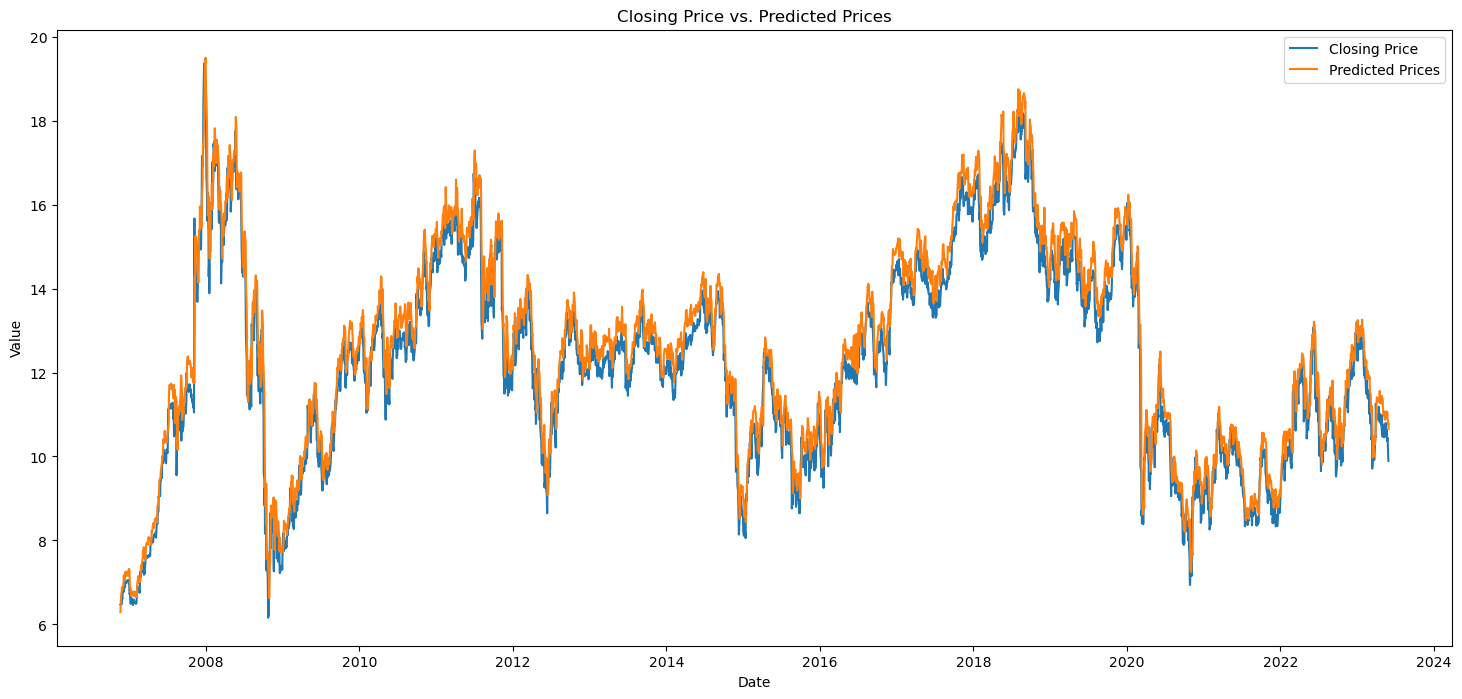

RMSE for test data is: 0.5686955854881478
r2 for test data is : 0.9461151854922367
predicted price for tomorrow based on todays date of 2023-05-31 00:00:00+01:00 is [[10.660571]]


In [11]:
df = load_file("GALP.LS_daily_data.xlsx")  # you can put your desired stock data to train model. Before using this model
                                            #dont forget to fine tune the model
df = localize_tz(df)
df = additive_decom(df)
df = calculate_technical_indicators(df)
X, y = split_data(df)


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
scaler_filename = "X_scaler.save"
joblib.dump(scaler, scaler_filename)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
scaler_filename = "y_scaler.save"
joblib.dump(scaler, scaler_filename)

# sequence of window for input
window_size = 20
# Create input sequences and corresponding labels
X_sequence, y_sequence = [], []

for i in range(window_size, len(X_scaled)):
    X_sequence.append(X_scaled[i-window_size:i])
    y_sequence.append(y_scaled[i])  

# Convert the data to numpy arrays
X_sequence, y_sequence = np.array(X_sequence), np.array(y_sequence)


# Reshape the data for input to the CNN-LSTM model
X_sequence = X_sequence.reshape((X_sequence.shape[0], X_sequence.shape[1], X_sequence.shape[2]))

# Build the model (best paremeter: filter_size': 64, 'kernel_size': 3, 'pool_size': 2, 'unit': 150, 'epoch': 10, 'batch_size': 20)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_sequence.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(125, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# Train the model
model.fit(X_sequence, y_sequence, epochs=13, batch_size=20)


# Evaluate the model on the test set
predicted_prices = model.predict(X_sequence)
# Inverse transform the predicted prices
predicted_prices = pd.DataFrame(scaler.inverse_transform(predicted_prices))

# Inverse transform the actual prices
actual_prices = pd.DataFrame(scaler.inverse_transform(y_sequence.reshape(-1, 1)))

# Claculate MSE
error = np.sqrt(mean_squared_error(actual_prices,predicted_prices))
r2 = r2_score(actual_prices.values, predicted_prices.values)


# Plot the desired output and predicted prices against the dates
plt.plot(X[window_size:-1].index, y[window_size:-1], label='Closing Price')
plt.plot(X.index[window_size:], predicted_prices.values, label='Predicted Prices')

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Closing Price vs. Predicted Prices')
plt.show()
print(f"RMSE for test data is: {error}")
print(f"r2 for test data is : {r2}")
print(f"predicted price for tomorrow based on todays date of {y[20:].index[-1]} is {predicted_prices.values[-1:]}")





In [12]:
model.save('galp_final.h5')


In [29]:
# Use this code to retreive the historical data from y_finance, you can define start time,
#end_time, and period (how many years, or days worth data you want, if you want to get all the data set period as max)

interval = '1d'
end_date = datetime.now().strftime('%Y-%m-%d')

# Retrieve data for each symbol
data = yf.download("GALP.LS", period = max,  interval= interval)

# Convert datetime values to timezone-naive
#Sdata.index = data.index  #.tz_localize(None)

# Create a dataframe for the stock data
df = pd.DataFrame(data)

filename = "GALP.LS_daily_data.xlsx"
df.to_excel(f"{filename}", index=True)



[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GALP.LS: AttributeError("'builtin_function_or_method' object has no attribute 'lower'")


In [39]:
predicte = predicted_prices.set_index(X[window_size:].index)
y = pd.concat([y, predicte], axis=1).reindex(y.index)
y

,target,0
Date,,
2006-10-24 00:00:00+01:00,6.256994,NaN
2006-10-25 00:00:00+01:00,6.287516,NaN
2006-10-26 00:00:00+01:00,6.155254,NaN
2006-10-27 00:00:00+01:00,6.084037,NaN
2006-10-30 00:00:00+00:00,6.094211,NaN
...,...,...
2023-05-30 00:00:00+01:00,9.896000,10.719558
2023-05-31 00:00:00+01:00,10.515000,10.625917
2023-06-02 00:00:00+01:00,10.505000,10.307466


In [32]:
# Load the dataset and perform preprocessing
df = load_file("./flask/uploads/GALP.LS_daily_data.xlsx")
df = localize_tz(df)
df = additive_decom(df)
df = calculate_technical_indicators(df)

# Prepare the features for prediction
X = df[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'RSI', 'EMA12',
'EMA24', 'MACD Line', 'MA12', 'MA24',
'BIAS12', 'BIAS24', 'Trend',
'Seasonality', 'Residual']]
y = df["target"]

# Scale the features and target
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))



# Prepare the input sequences
window_size = 20
X_test = []
for i in range(window_size, len(X_scaled)):
    X_test.append(X_scaled[i - window_size:i])

X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# Construct the absolute file path to load and save model
base_path = "galp_final.h5"
loaded_model = load_model(base_path)
# Make predictions
pred = loaded_model.predict(X_test)                                 
predicted_prices = pd.DataFrame(scaler.inverse_transform(pred))
#predicted_price = predicted_prices.set_index(X[window_size:].index)
#y = pd.concat([y, predicted_price], axis=1).reindex(y.index)

# Get the last predicted price
last_predicted_price = predicted_prices.iloc[-1][0]

22/22 [==============================] - 1s 9ms/step


In [33]:
error = np.sqrt(mean_squared_error(y[window_size:], predicted_prices)).round(2)
r2 = r2_score(y[window_size:], predicted_prices.values)
print(error)
print(r2)

1.76
-0.8402332157563361


In [3]:
#This code is for prediction data download with period 60
interval = '1d'
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=1460)).strftime('%Y-%m-%d')
# Retrieve data for each symbol
data = yf.download("GALP.LS", start= start_date,  end = end_date, interval= interval)

# Convert datetime values to timezone-naive
data.index = data.index#.tz_localize(None)

# Create a dataframe for the stock data
df = pd.DataFrame(data)

filename = "./flask/uploads/GALP.LS_daily_data.xlsx"
df.to_excel(f"{filename}", index=True)

[*********************100%***********************]  1 of 1 completed
